In [1]:
RANDOM_SEED = 42

In [2]:
import pickle
import pathlib

import numpy as np
import pandas as pd

In [3]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/Users/antonioamaralegydiomartins/Developer/Insper/Eletivas/Untitled/projeto1-ml-ames/data


In [4]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
clean_data_path

PosixPath('/Users/antonioamaralegydiomartins/Developer/Insper/Eletivas/Untitled/projeto1-ml-ames/data/processed/ames_clean.pkl')

In [5]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1154 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      1154 non-null   category
 1   MS.Zoning        1154 non-null   category
 2   Lot.Frontage     1154 non-null   float64 
 3   Lot.Area         1154 non-null   float64 
 4   Lot.Shape        1154 non-null   category
 5   Land.Contour     1154 non-null   category
 6   Lot.Config       1154 non-null   category
 7   Land.Slope       1154 non-null   category
 8   Neighborhood     1154 non-null   category
 9   Bldg.Type        1154 non-null   category
 10  House.Style      1154 non-null   category
 11  Overall.Qual     1154 non-null   category
 12  Overall.Cond     1154 non-null   category
 13  Roof.Style       1154 non-null   category
 14  Mas.Vnr.Type     1154 non-null   category
 15  Mas.Vnr.Area     1154 non-null   float64 
 16  Exter.Qual       1154 non-null   category
 17  

In [7]:
model_data = data.copy()
model_data.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Bldg.Type,...,Sale.Type,Sale.Condition,SalePrice,Condition,HasShed,HasAlley,Exterior,Garage.Age,Remod.Age,House.Age
0,20,RL,141.0,31770.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.332438,Norm,False,False,BrkFace,50.0,50.0,50.0
2,20,RL,81.0,14267.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.235528,Norm,False,False,Wd Sdng,52.0,52.0,52.0
5,60,RL,78.0,9978.0,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,...,GroupedWD,Normal,5.291147,Norm,False,False,VinylSd,12.0,12.0,12.0
15,60,RL,47.0,53504.0,IR2,HLS,CulDSac,Mod,StoneBr,1Fam,...,GroupedWD,Normal,5.730782,Norm,False,False,CemntBd,7.0,7.0,7.0
17,20,RL,88.0,11394.0,Reg,Lvl,Corner,Gtl,StoneBr,1Fam,...,New,Partial,5.595972,Norm,False,False,VinylSd,0.0,0.0,0.0


In [8]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [9]:
numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
target = data['SalePrice'].copy()
numerical_data.corrwith(target).sort_values()



ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [10]:
categorical_columns


['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

In [11]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

In [12]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1154 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Lot.Shape     1154 non-null   int64
 1   Land.Slope    1154 non-null   int64
 2   Overall.Qual  1154 non-null   int64
 3   Overall.Cond  1154 non-null   int64
 4   Exter.Qual    1154 non-null   int64
 5   Exter.Cond    1154 non-null   int64
 6   Heating.QC    1154 non-null   int64
 7   Electrical    1154 non-null   int64
 8   Kitchen.Qual  1154 non-null   int64
 9   Functional    1154 non-null   int64
 10  Paved.Drive   1154 non-null   int64
 11  Fence         1154 non-null   int64
dtypes: int64(12)
memory usage: 117.2 KB


In [13]:
data['Lot.Shape'].value_counts()

Lot.Shape
Reg    644
IR1    481
IR2     23
IR3      6
Name: count, dtype: int64

In [14]:
model_data['Lot.Shape'].value_counts()

Lot.Shape
0    644
1    481
2     23
3      6
Name: count, dtype: int64

In [15]:
model_data['Exterior'].value_counts()

Exterior
VinylSd    521
HdBoard    235
MetalSd    136
Plywood     91
Wd Sdng     89
CemntBd     54
WdShing     14
Stucco       7
AsbShng      4
BrkFace      3
Name: count, dtype: int64

In [16]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,2,5,15,17
AsbShng,False,False,False,False,False
BrkFace,True,False,False,False,False
CemntBd,False,False,False,True,False
HdBoard,False,False,False,False,False
MetalSd,False,False,False,False,False
Plywood,False,False,False,False,False
Stucco,False,False,False,False,False
VinylSd,False,False,True,False,True
Wd Sdng,False,True,False,False,False
WdShing,False,False,False,False,False


In [17]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,2,5,15,17
BrkFace,True,False,False,False,False
CemntBd,False,False,False,True,False
HdBoard,False,False,False,False,False
MetalSd,False,False,False,False,False
Plywood,False,False,False,False,False
Stucco,False,False,False,False,False
VinylSd,False,False,True,False,True
Wd Sdng,False,True,False,False,False
WdShing,False,False,False,False,False
Exterior,BrkFace,Wd Sdng,VinylSd,CemntBd,VinylSd


In [18]:
model_data = pd.get_dummies(model_data, drop_first=True)

In [19]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1154 entries, 0 to 2929
Columns: 160 entries, Lot.Frontage to Exterior_WdShing
dtypes: bool(114), float64(34), int64(12)
memory usage: 552.2 KB


In [20]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_SawyerW", "Neighborhood_So

In [21]:
X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

In [22]:
X.values, y.values

(array([[141.0, 31770.0, 1, ..., False, False, False],
        [81.0, 14267.0, 1, ..., False, True, False],
        [78.0, 9978.0, 1, ..., True, False, False],
        ...,
        [32.0, 4500.0, 0, ..., True, False, False],
        [80.0, 13384.0, 0, ..., False, False, False],
        [74.0, 9627.0, 0, ..., False, False, False]], dtype=object),
 array([5.33243846, 5.23552845, 5.29114676, ..., 5.18610838, 5.14612804,
        5.27415785]))

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [25]:
X.shape, Xtrain.shape, Xtest.shape

((1154, 159), (865, 159), (289, 159))

In [26]:
y.shape, ytrain.shape, ytest.shape

((1154,), (865,), (289,))

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



grid_search_forest = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    {'n_estimators': [300, 675, 900]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

grid_search_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    {'max_depth': [3, 5, 7]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)


In [28]:
grid_search_forest.fit(Xtrain, ytrain)
forest_reg = grid_search_forest.best_estimator_
forest_reg_scores = cross_val_score(forest_reg, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)

In [29]:
forest_reg

RandomForestRegressor(n_estimators=900, n_jobs=-1, random_state=42)

In [30]:
grid_search_tree.fit(Xtrain, ytrain)
tree_reg = grid_search_tree.best_estimator_
tree_reg_scores = cross_val_score(tree_reg, Xtrain, ytrain, 
                                  scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
tree_reg_rmse_scores = np.sqrt(-tree_reg_scores)

In [31]:
print("Random Forest Regressor:")
print(forest_reg_rmse_scores)
print(forest_reg_rmse_scores.mean())
print("\nDecision Tree Regressor:")
print(tree_reg_rmse_scores)
print(tree_reg_rmse_scores.mean())

Random Forest Regressor:
[0.05483362 0.05373239 0.0628648  0.04888524 0.06837792 0.06780074
 0.05122238 0.04540094]
0.05663975501158934

Decision Tree Regressor:
[0.0743715  0.08074921 0.07412163 0.07348744 0.1049488  0.09729241
 0.07753719 0.06258454]
0.0806365912825773


In [32]:
# testando um teste parametrico
from scipy.stats import ttest_ind

def compara_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))

In [33]:
from scipy.stats import mannwhitneyu

U, p_value = mannwhitneyu(forest_reg_rmse_scores, tree_reg_rmse_scores)
print('U =', U)
print('p-value =', p_value)

U = 3.0
p-value = 0.0010878010878010878


In [34]:
compara_scores(forest_reg_rmse_scores, tree_reg_rmse_scores)

Valor da estatística t: -4.16
Valor-p: 0.0013787319484881175


In [35]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [36]:
def outro_experimento(msg, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_pred, y_test))

    print(f'{msg}:')
    print(f'RMSE: {RMSE}')
    print()

In [37]:
poly_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ('reg', forest_reg)
])

In [38]:
# outro_experimento('Random Forest com PolynomialFeatures', poly_reg, Xtrain, ytrain, Xtest, ytest)

In [39]:
# stacking regressors -> Random Forest + Decision Tree + Lasso
from sklearn.ensemble import StackingRegressor
# import gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Grid search for Gradient Boosting Regressor
grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    {'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_gbr.fit(Xtrain, ytrain)
gbr_reg = grid_search_gbr.best_estimator_
print(gbr_reg)


GradientBoostingRegressor(max_depth=2, n_estimators=425, random_state=42)


In [40]:
gbr_reg

GradientBoostingRegressor(max_depth=2, n_estimators=425, random_state=42)

In [41]:
# Lasso GridSearch
grid_search_lasso = GridSearchCV(
    Lasso(random_state=RANDOM_SEED),
    {'alpha': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_lasso.fit(Xtrain, ytrain)
lasso_reg = grid_search_lasso.best_estimator_
print(lasso_reg)

Lasso(alpha=0.1, random_state=42)


In [70]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge 
from sklearn.linear_model import QuantileRegressor

import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class QuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        self.model = None

    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y

        self.model = sm.QuantReg(y, X).fit(q=self.alpha)

    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        return self.model.predict(X)



param_grid_quantile = {
    'alpha': [0.1, 0.25, 0.5, 0.75, 0.9]  
}


grid_search_quantile = GridSearchCV(
    QuantileRegressor(),
    param_grid_quantile,
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)


grid_search_quantile.fit(Xtrain, ytrain)


quantile_reg = grid_search_quantile.best_estimator_



In [84]:
from sklearn.svm import SVR
svr_reg = SVR()

estimators = [
    ('svr', svr_reg) ,
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg),
]

from sklearn.linear_model import HuberRegressor

huber_reg = HuberRegressor()

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=huber_reg  
)

stack_reg.fit(Xtrain, ytrain)

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                   scoring='neg_mean_squared_error', cv=8, n_jobs=-1,)
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)
print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e-02, tolerance: 2.400e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e-02, tolerance: 1.965e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[0.05045575 0.05194524 0.05759412 0.047068   0.08464577 0.0618448
 0.05160628 0.04349466]
0.05608182771292271


In [85]:
# Cross Validation of Stacking Regressor
from sklearn.model_selection import cross_val_score

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.290e-01, tolerance: 2.109e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.407e-01, tolerance: 2.114e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[0.05045564 0.05194523 0.05759406 0.047068   0.08464577 0.06184479
 0.05160628 0.04349466]
0.05608180494351869


In [86]:
mean_scores = stack_reg_rmse_scores.mean()
# uma vez que o target está em log, precisamos fazer a transformação inversa
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

13.784159271690255


Text(0.5, 1.0, 'Feature Importance (MDI)')

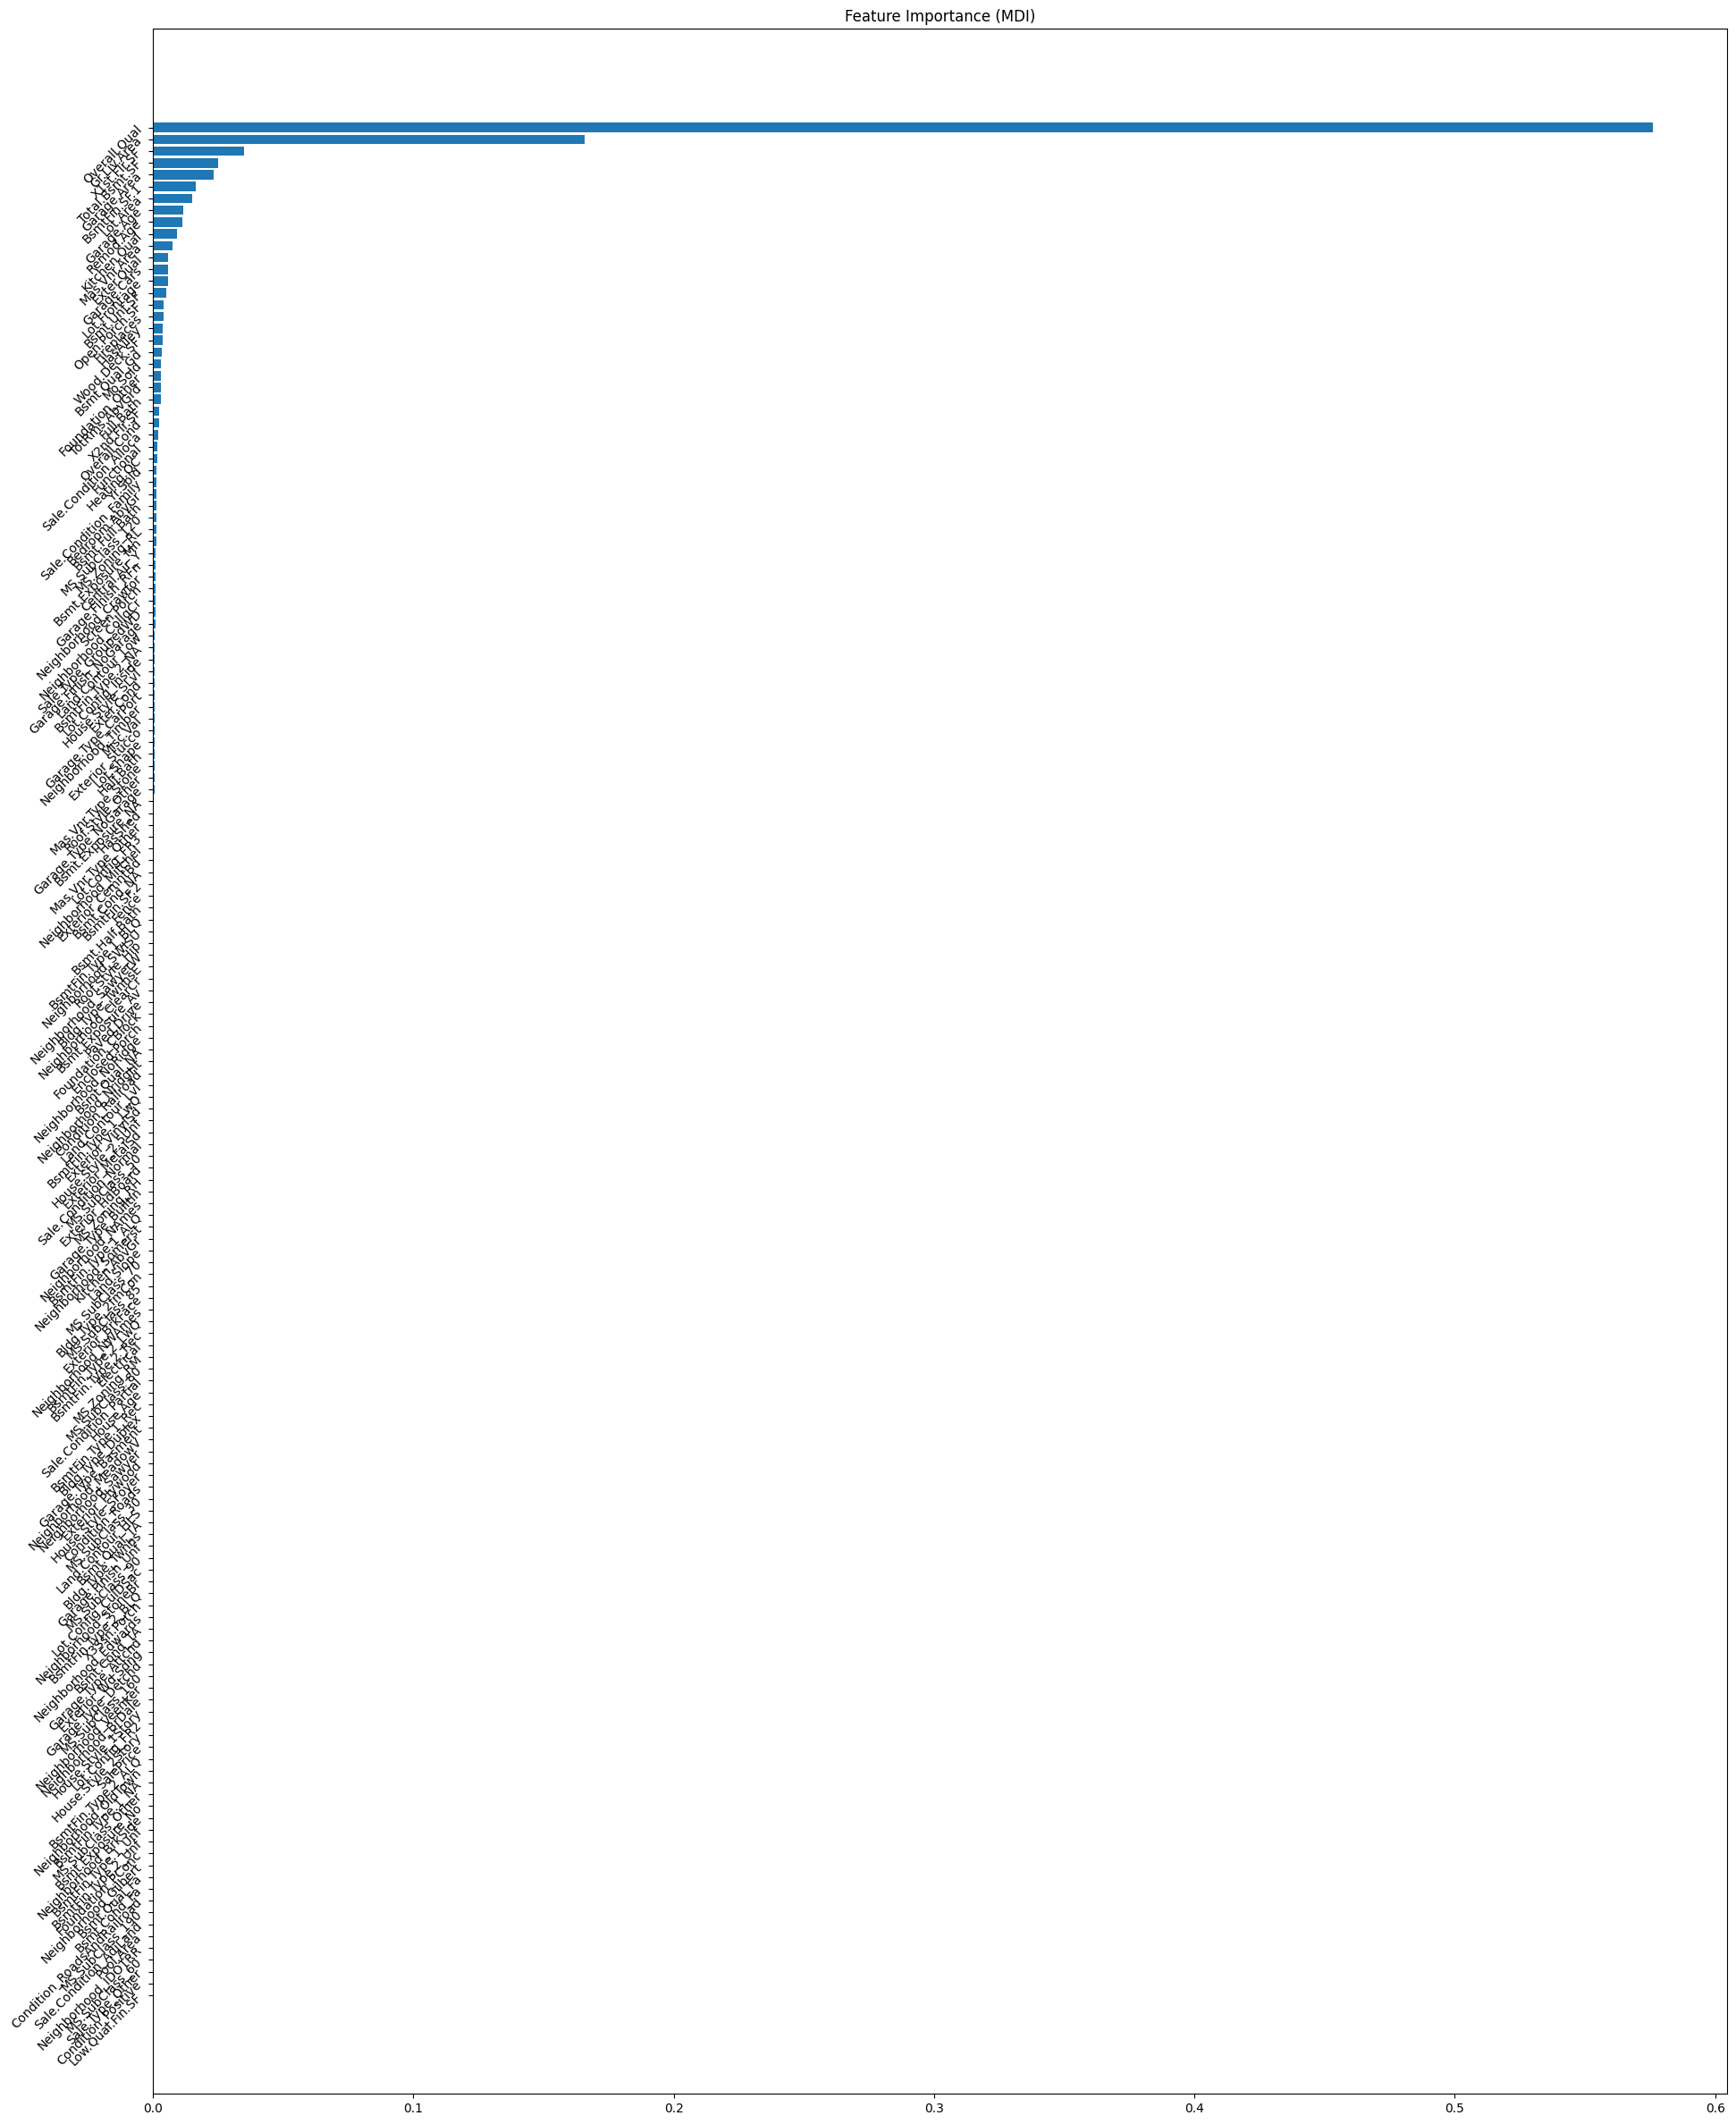

In [45]:
import matplotlib.pyplot as plt


feature_importance_forest = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_forest)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_forest[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

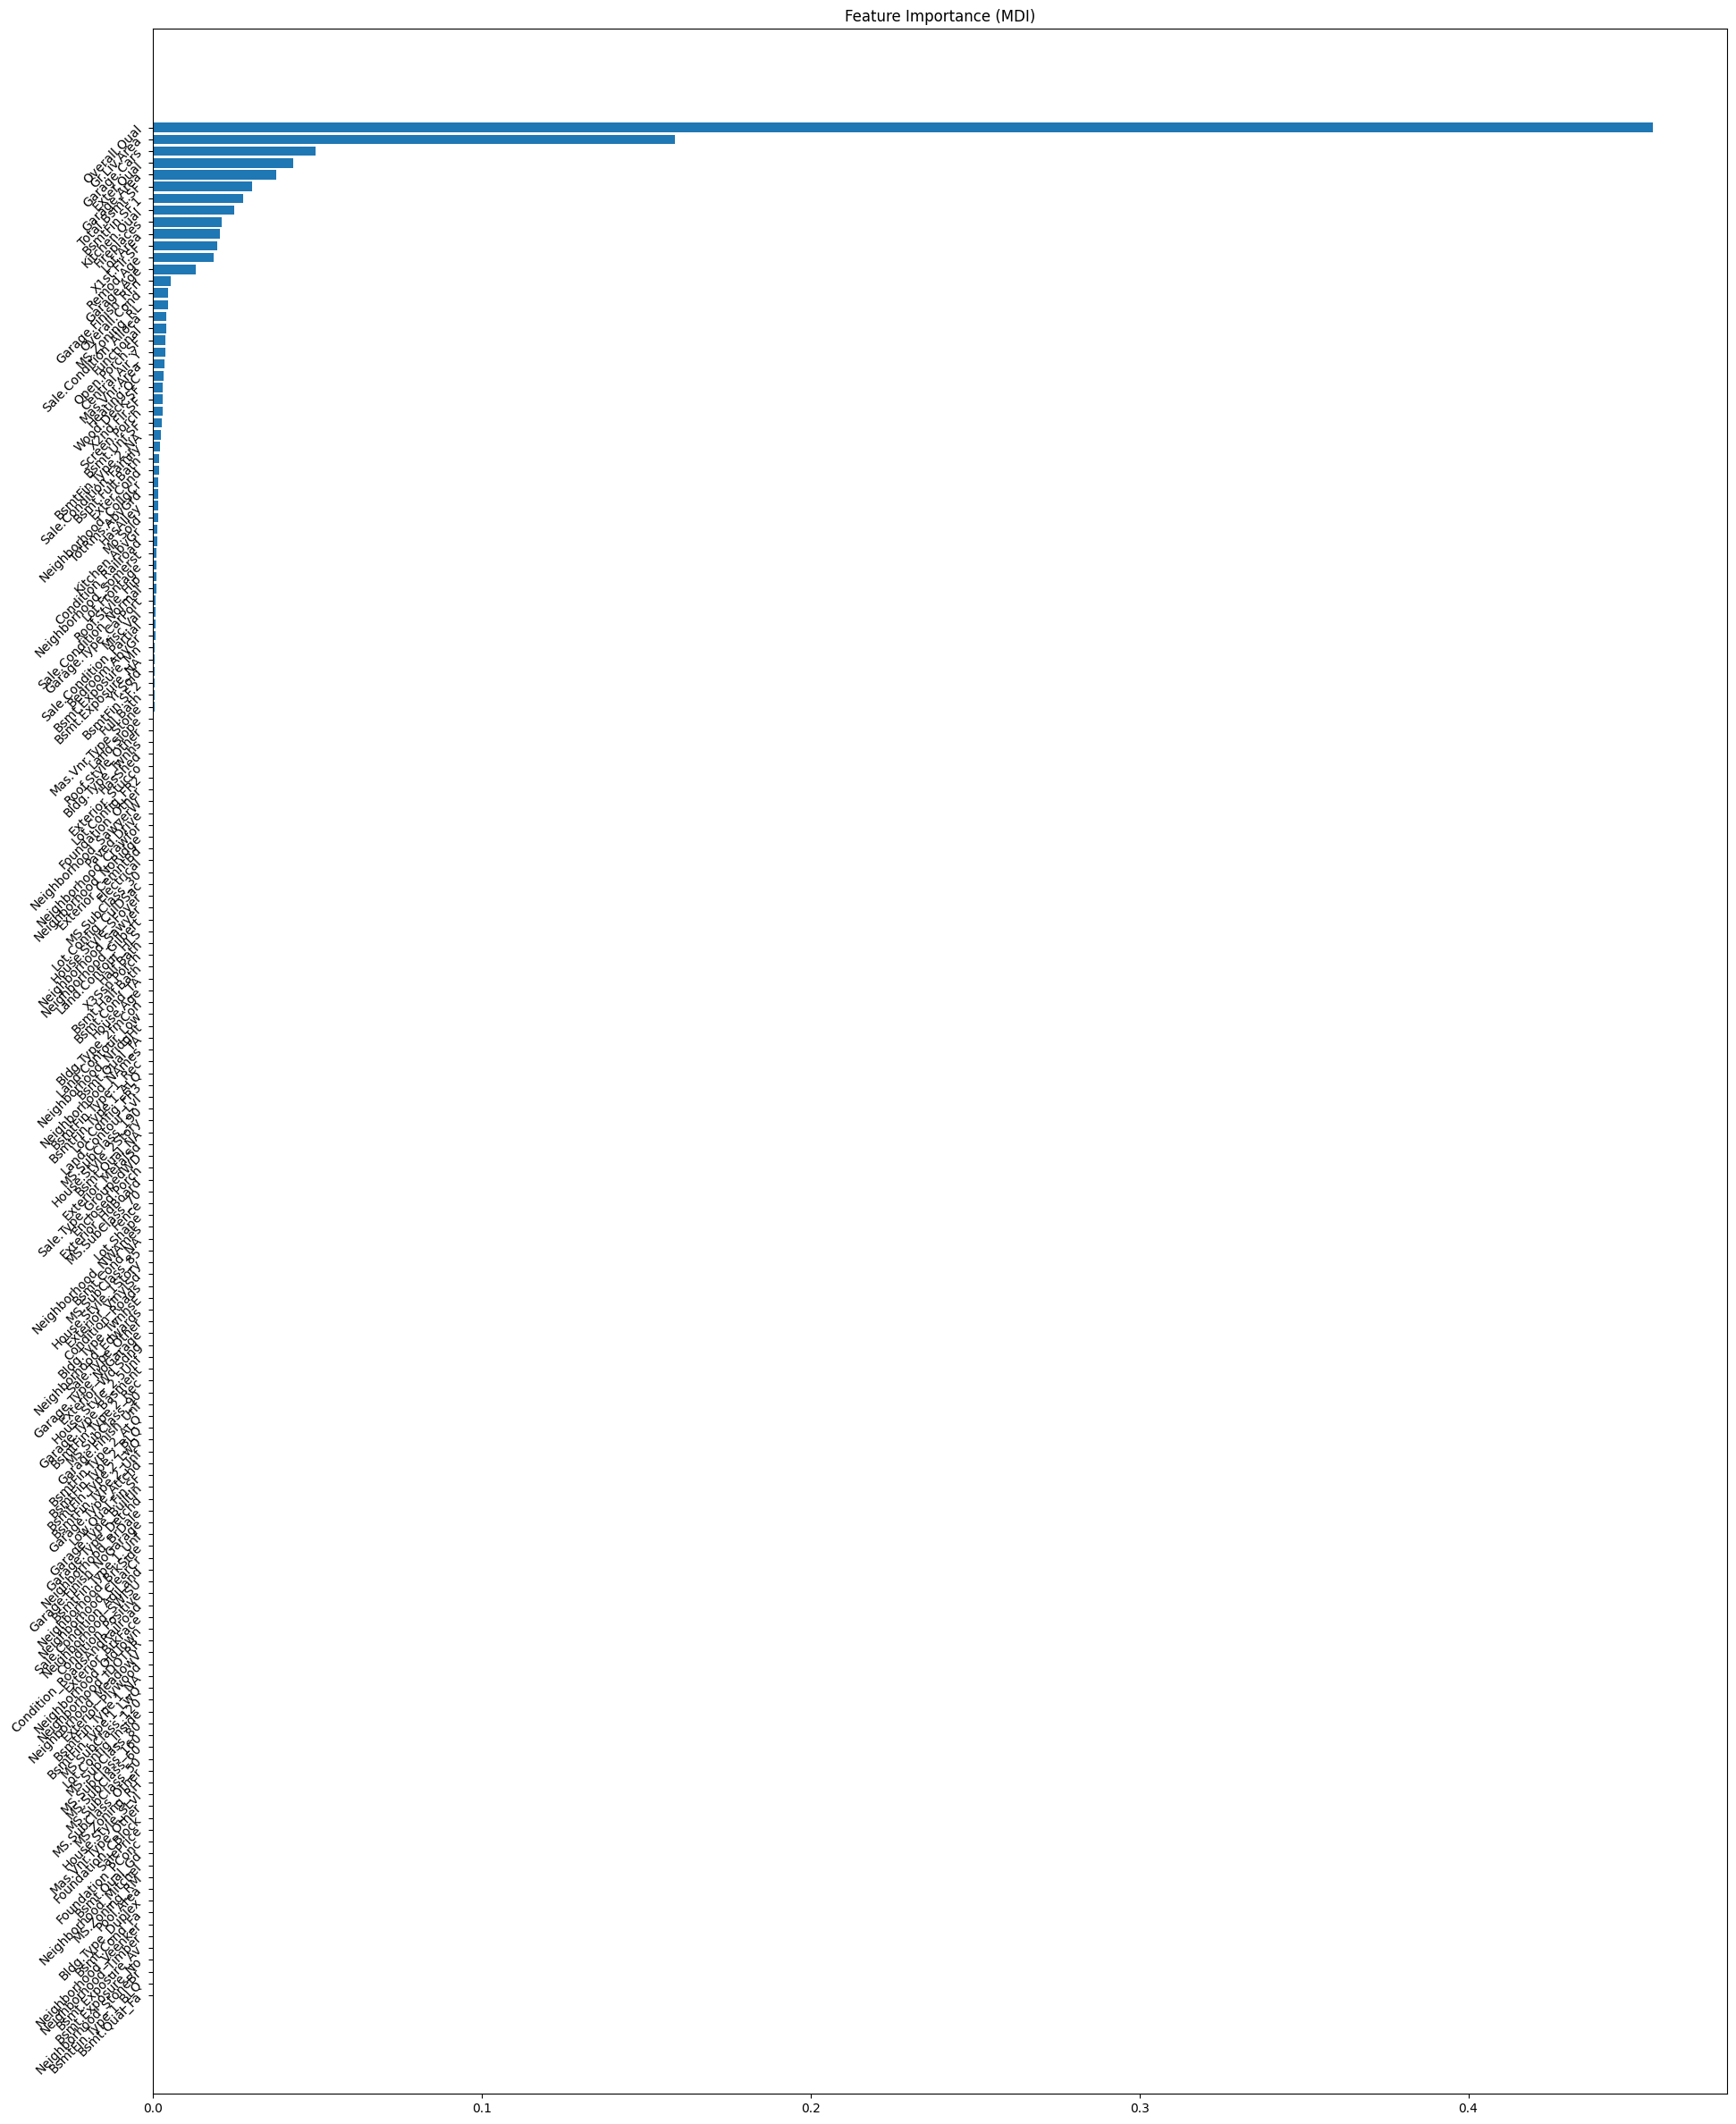

In [46]:
feature_importance_gbr = gbr_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_gbr)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_gbr[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

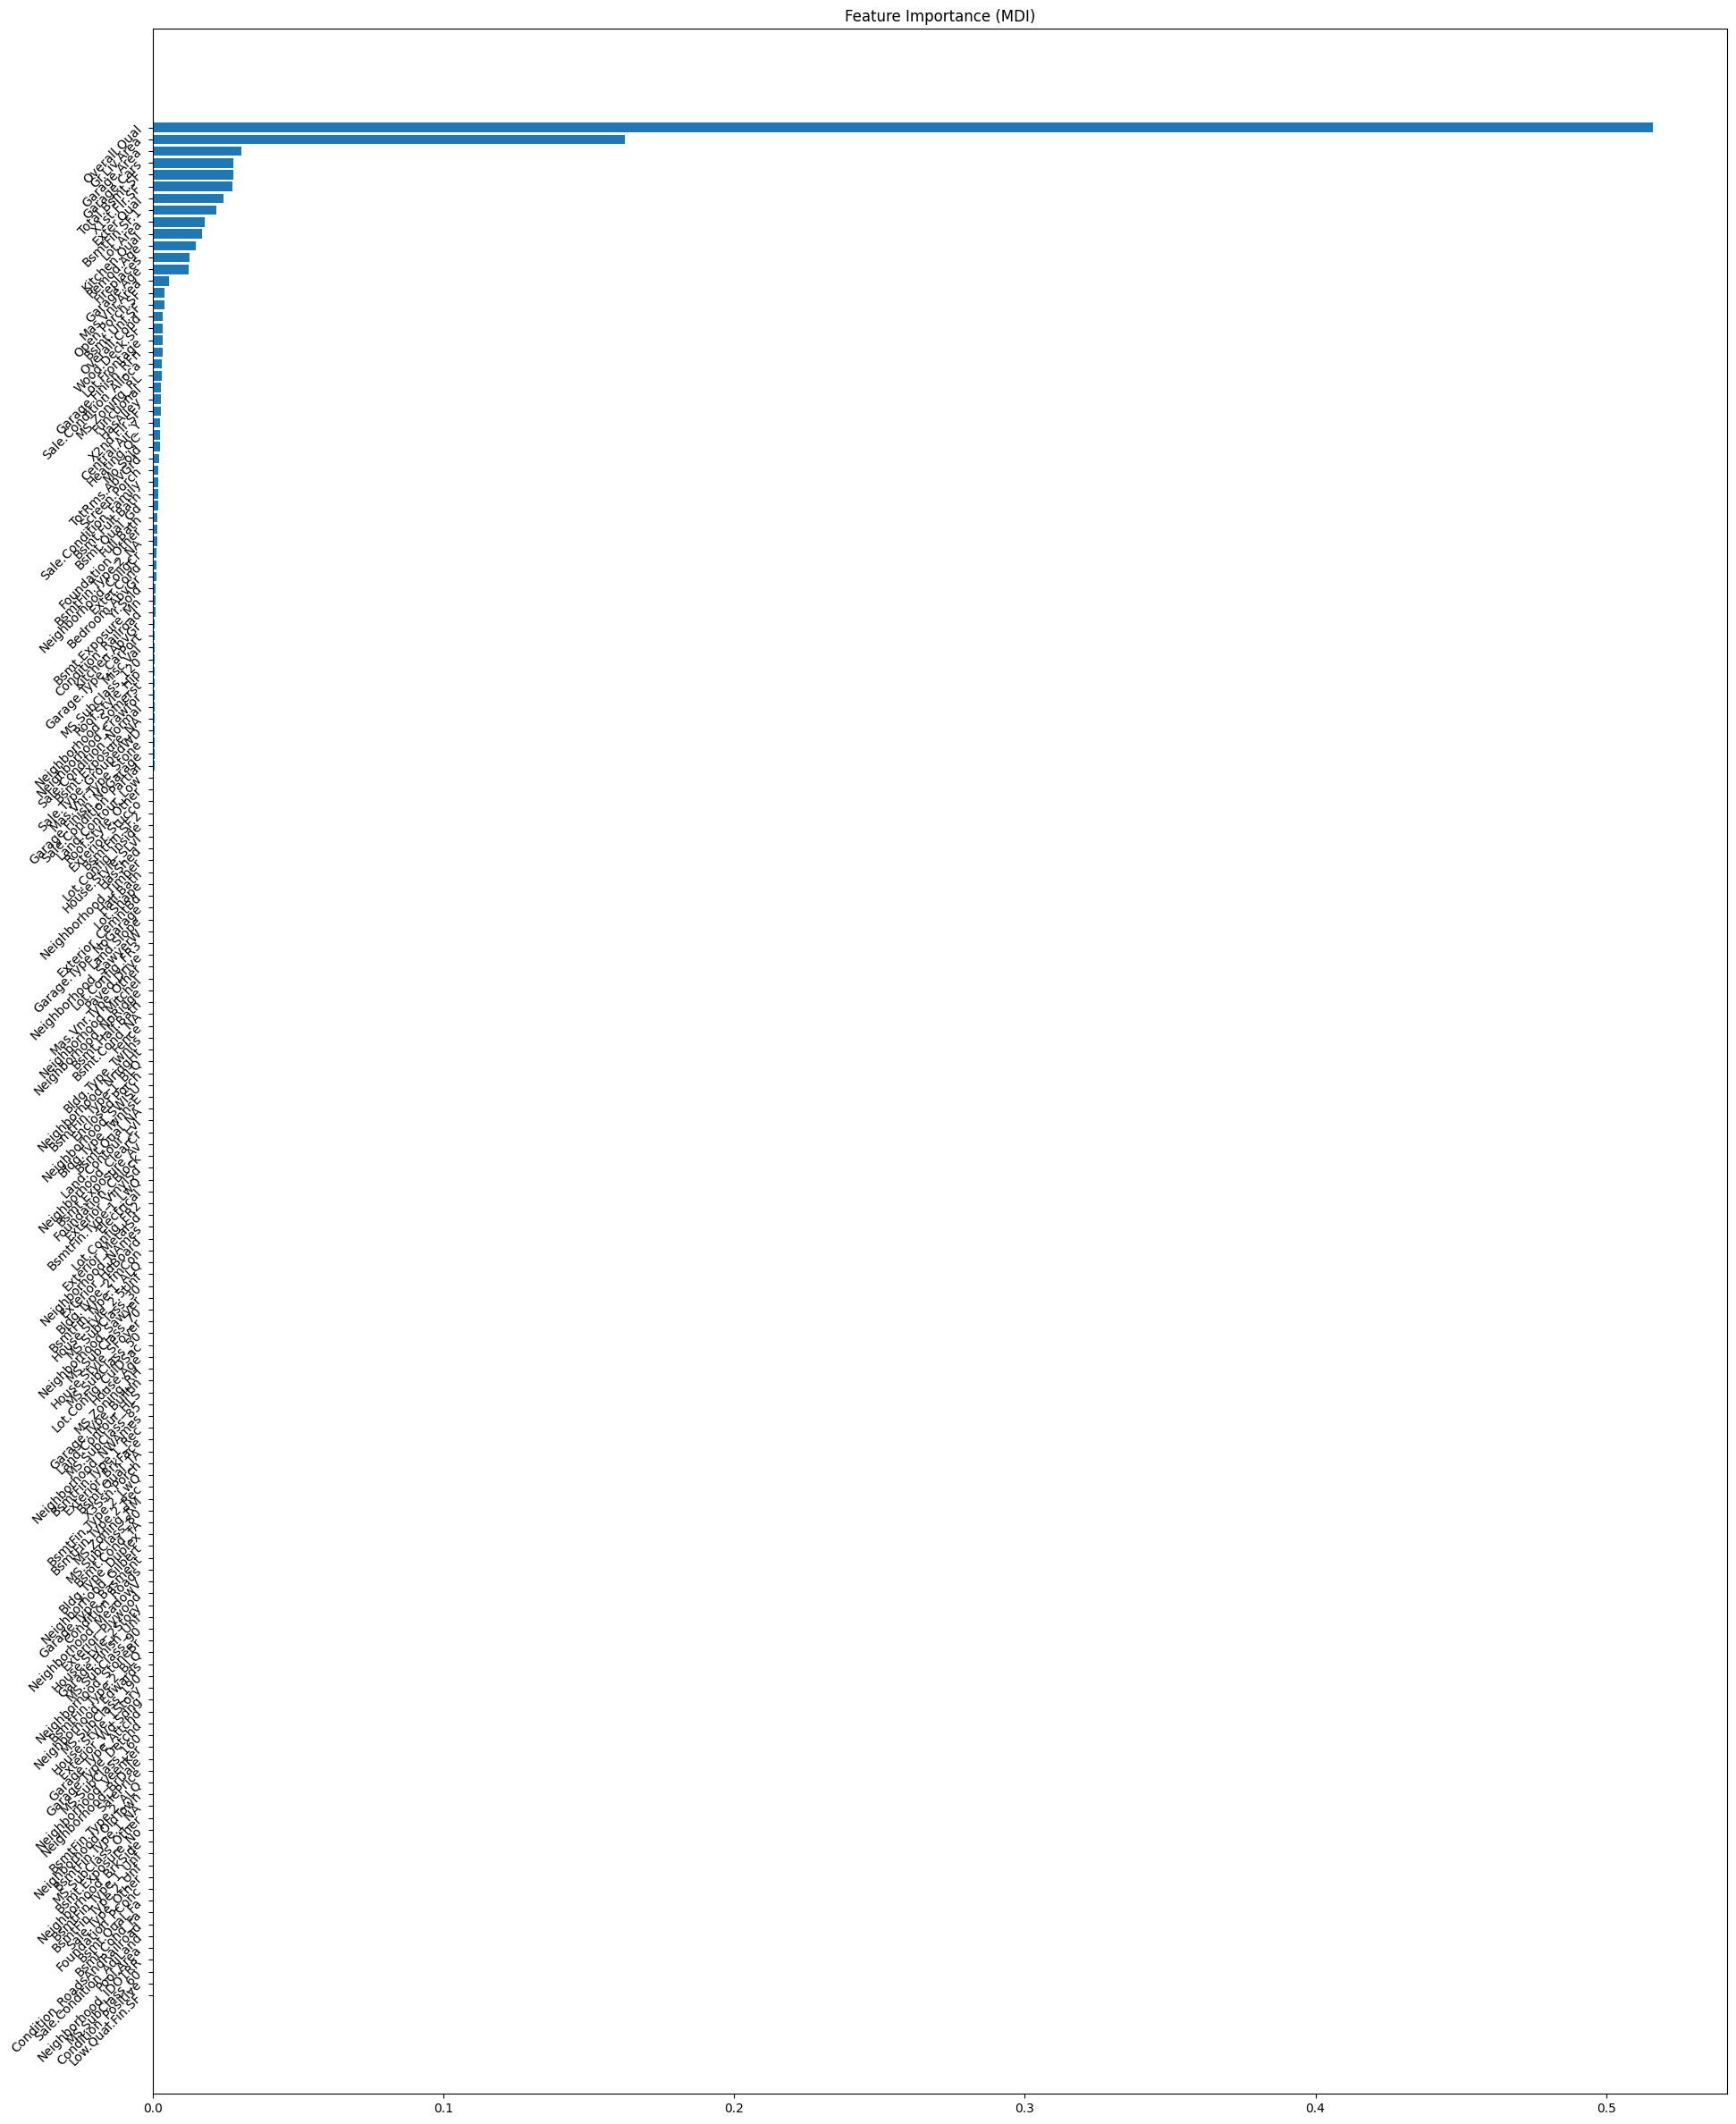

In [47]:
# Faz a média da importância das features
feature_importance = (feature_importance_forest + feature_importance_gbr) / 2
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")



In [48]:
# Filtra as 10 features mais importantes
top_15_features = np.array(model_data.columns)[sorted_idx][-15:]
top_15_features


array(['Open.Porch.SF', 'Mas.Vnr.Area', 'Garage.Age', 'Fireplaces',
       'Remod.Age', 'Kitchen.Qual', 'Lot.Area', 'BsmtFin.SF.1',
       'Exter.Qual', 'X1st.Flr.SF', 'Total.Bsmt.SF', 'Garage.Cars',
       'Garage.Area', 'Gr.Liv.Area', 'Overall.Qual'], dtype=object)

In [49]:
# print the 15 most important features and their importance score
print('Feature Importance Score')
print('------------------------')
for i,v in enumerate(feature_importance[sorted_idx][-15:]):
    print(f'Feature: {top_15_features[i]}, Score: {v}')
    

Feature Importance Score
------------------------
Feature: Open.Porch.SF, Score: 0.0039853268239803934
Feature: Mas.Vnr.Area, Score: 0.005512586122656857
Feature: Garage.Age, Score: 0.012295174397038294
Feature: Fireplaces, Score: 0.01247906925861739
Feature: Remod.Age, Score: 0.014825956659508425
Feature: Kitchen.Qual, Score: 0.016966915098704956
Feature: Lot.Area, Score: 0.01776118744260037
Feature: BsmtFin.SF.1, Score: 0.021957033559769988
Feature: Exter.Qual, Score: 0.024348536598916278
Feature: X1st.Flr.SF, Score: 0.027292425209709703
Feature: Total.Bsmt.SF, Score: 0.027654044174129325
Feature: Garage.Cars, Score: 0.027669281566955833
Feature: Garage.Area, Score: 0.030326926797955636
Feature: Gr.Liv.Area, Score: 0.16225875734223627
Feature: Overall.Qual, Score: 0.5159577491086469


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


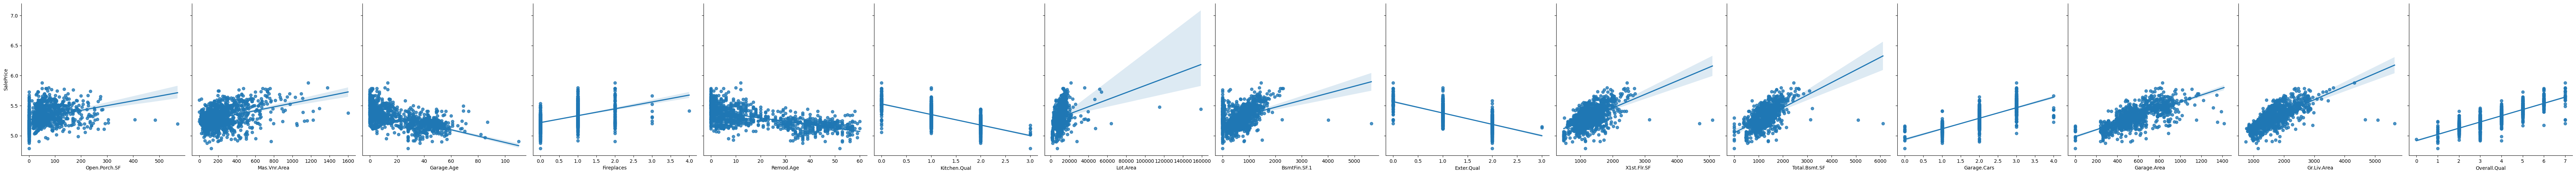

In [50]:
# faz o gráfico de dispersão das 10 features mais importantes
import seaborn as sns

sns.pairplot(model_data, x_vars=top_15_features, y_vars='SalePrice', height=5, aspect=1, kind='reg')


In [51]:
# cria um dataframe com as 10 features mais importantes
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df.head()

# cria um dataframe com as 10 features mais importantes e o target
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df['SalePrice'] = model_data['SalePrice'].copy()
top_15_features_df.corr()


,Open.Porch.SF,Mas.Vnr.Area,Garage.Age,Fireplaces,Remod.Age,Kitchen.Qual,Lot.Area,BsmtFin.SF.1,Exter.Qual,X1st.Flr.SF,Total.Bsmt.SF,Garage.Cars,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice
Open.Porch.SF,1.000000,0.143324,-0.202649,0.163984,-0.230219,-0.233623,0.194941,0.160219,-0.236694,0.256622,0.255479,0.225860,0.261437,0.367883,0.265746,0.305555
Mas.Vnr.Area,0.143324,1.000000,-0.085656,0.231881,-0.085038,-0.245325,0.202109,0.229486,-0.263446,0.318093,0.307218,0.246844,0.311785,0.461765,0.345263,0.380065
Garage.Age,-0.202649,-0.085656,1.000000,-0.013766,0.847422,0.651310,0.078865,-0.127289,0.720468,-0.245782,-0.354170,-0.589144,-0.510179,-0.308703,-0.694131,-0.610599
Fireplaces,0.163984,0.231881,-0.013766,1.000000,-0.091186,-0.211548,0.293757,0.269613,-0.201038,0.421962,0.320590,0.293408,0.307245,0.448159,0.310621,0.440539
Remod.Age,-0.230219,-0.085038,0.847422,-0.091186,1.000000,0.684124,-0.008670,-0.128157,0.697953,-0.253012,-0.309731,-0.531417,-0.453592,-0.325604,-0.662804,-0.613232
Kitchen.Qual,-0.233623,-0.245325,0.651310,-0.211548,0.684124,1.000000,-0.109543,-0.258158,0.781304,-0.399934,-0.453468,-0.540111,-0.524931,-0.451903,-0.745519,-0.721897
Lot.Area,0.194941,0.202109,0.078865,0.293757,-0.008670,-0.109543,1.000000,0.229606,-0.078547,0.362580,0.325506,0.182846,0.259010,0.355941,0.131219,0.265439
BsmtFin.SF.1,0.160219,0.229486,-0.127289,0.269613,-0.128157,-0.258158,0.229606,1.000000,-0.245083,0.468278,0.522747,0.211307,0.298660,0.244861,0.263110,0.360067
Exter.Qual,-0.236694,-0.263446,0.720468,-0.201038,0.697953,0.781304,-0.078547,-0.245083,1.000000,-0.411475,-0.490560,-0.553617,-0.540066,-0.437981,-0.775005,-0.720529
X1st.Flr.SF,0.256622,0.318093,-0.245782,0.421962,-0.253012,-0.399934,0.362580,0.468278,-0.411475,1.000000,0.876571,0.436675,0.525619,0.524837,0.494695,0.566730


In [52]:
# feature engineering
# cria uma nova feature com a soma das 15 features mais importantes
top_15_features_df['sum_15_features'] = top_15_features_df[top_15_features].sum(axis=1)
top_15_features_df.head()

,Open.Porch.SF,Mas.Vnr.Area,Garage.Age,Fireplaces,Remod.Age,Kitchen.Qual,Lot.Area,BsmtFin.SF.1,Exter.Qual,X1st.Flr.SF,Total.Bsmt.SF,Garage.Cars,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice,sum_15_features
0,62.0,112.0,50.0,2.0,50.0,2,31770.0,639.0,2,1656.0,1080.0,2.0,528.0,1656.0,3,5.332438,37614.0
2,36.0,108.0,52.0,0.0,52.0,1,14267.0,923.0,2,1329.0,1329.0,1.0,312.0,1329.0,3,5.235528,19744.0
5,36.0,20.0,12.0,1.0,12.0,1,9978.0,602.0,2,926.0,926.0,2.0,470.0,1604.0,3,5.291147,14595.0
15,36.0,603.0,7.0,1.0,7.0,0,53504.0,1416.0,0,1690.0,1650.0,3.0,841.0,3279.0,5,5.730782,63042.0
17,0.0,350.0,0.0,1.0,0.0,0,11394.0,1445.0,1,1856.0,1856.0,3.0,834.0,1856.0,6,5.595972,19602.0


In [53]:
# correlação da nova feature com o target
top_15_features_df.corr()


,Open.Porch.SF,Mas.Vnr.Area,Garage.Age,Fireplaces,Remod.Age,Kitchen.Qual,Lot.Area,BsmtFin.SF.1,Exter.Qual,X1st.Flr.SF,Total.Bsmt.SF,Garage.Cars,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice,sum_15_features
Open.Porch.SF,1.000000,0.143324,-0.202649,0.163984,-0.230219,-0.233623,0.194941,0.160219,-0.236694,0.256622,0.255479,0.225860,0.261437,0.367883,0.265746,0.305555,0.251265
Mas.Vnr.Area,0.143324,1.000000,-0.085656,0.231881,-0.085038,-0.245325,0.202109,0.229486,-0.263446,0.318093,0.307218,0.246844,0.311785,0.461765,0.345263,0.380065,0.289822
Garage.Age,-0.202649,-0.085656,1.000000,-0.013766,0.847422,0.651310,0.078865,-0.127289,0.720468,-0.245782,-0.354170,-0.589144,-0.510179,-0.308703,-0.694131,-0.610599,-0.000612
Fireplaces,0.163984,0.231881,-0.013766,1.000000,-0.091186,-0.211548,0.293757,0.269613,-0.201038,0.421962,0.320590,0.293408,0.307245,0.448159,0.310621,0.440539,0.361099
Remod.Age,-0.230219,-0.085038,0.847422,-0.091186,1.000000,0.684124,-0.008670,-0.128157,0.697953,-0.253012,-0.309731,-0.531417,-0.453592,-0.325604,-0.662804,-0.613232,-0.076850
Kitchen.Qual,-0.233623,-0.245325,0.651310,-0.211548,0.684124,1.000000,-0.109543,-0.258158,0.781304,-0.399934,-0.453468,-0.540111,-0.524931,-0.451903,-0.745519,-0.721897,-0.205274
Lot.Area,0.194941,0.202109,0.078865,0.293757,-0.008670,-0.109543,1.000000,0.229606,-0.078547,0.362580,0.325506,0.182846,0.259010,0.355941,0.131219,0.265439,0.981398
BsmtFin.SF.1,0.160219,0.229486,-0.127289,0.269613,-0.128157,-0.258158,0.229606,1.000000,-0.245083,0.468278,0.522747,0.211307,0.298660,0.244861,0.263110,0.360067,0.348596
Exter.Qual,-0.236694,-0.263446,0.720468,-0.201038,0.697953,0.781304,-0.078547,-0.245083,1.000000,-0.411475,-0.490560,-0.553617,-0.540066,-0.437981,-0.775005,-0.720529,-0.179128
X1st.Flr.SF,0.256622,0.318093,-0.245782,0.421962,-0.253012,-0.399934,0.362580,0.468278,-0.411475,1.000000,0.876571,0.436675,0.525619,0.524837,0.494695,0.566730,0.506885


# Teste das alterações

In [54]:
# train test split
X = top_15_features_df.drop(columns=['SalePrice']).copy()
y = top_15_features_df['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

In [55]:
# testa o modelo de stacking regressor só com as 15 features mais importantes e a nova feature criada

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e-02, tolerance: 2.140e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.407e-01, tolerance: 2.114e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[0.05098269 0.05215192 0.05848667 0.04730893 0.08756916 0.06407743
 0.0522973  0.04331434]
0.057023551985034074


In [56]:
# converte o resultado para o valor original
mean_scores = stack_reg_rmse_scores.mean()
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

14.03116254965957


# Analisando Correlações + Features
Inicialmente utilizamos o RandomForest e DecisionTree buscar entender como um modelo complexo interage com nosso banco de dados. Com os benchmarks feitos, buscamos outras formas e modelos que pudessemos implementar, que reduzissem a porcentagem de erro. Com isso chegamos no StakingRegressor em que utilizamos três regressores em formato de stack.

```python
estimators = [
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg)    
]
```

Após plotar o gráfico das importâncias médias das features, percebemos que apenas 10 features estavam ditando o resultado do modelo. Para solucionar isso, agora daremos inicio a mais uma rodada, adicional a realizada no documento <b>02_analysis_and_preprocessing</b> buscando correlações entre duas ou mais features que poderiam ser múltiplicadas.

## Quais são as 10 Features que ditam o modelo?

1. Lot.Area
2. Exter.Qual
3. BsmtFin.SF.2
4. Overall.Cond
5. Heating.QC
6. Land.Slope
7. Mas.Vn.Area
8. Bsmt.Unf.SF
9. Overall.Qual
10. Exter.Cond

## Quais pares de Features podem ser multiplicados?

1. 


In [57]:
model_data.head()

,Lot.Frontage,Lot.Area,Lot.Shape,Land.Slope,Overall.Qual,Overall.Cond,Mas.Vnr.Area,Exter.Qual,Exter.Cond,BsmtFin.SF.1,...,Condition_RoadsAndRailroad,Exterior_BrkFace,Exterior_CemntBd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Plywood,Exterior_Stucco,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing
0,141.0,31770.0,1,0,3,3,112.0,2,2,639.0,...,False,True,False,False,False,False,False,False,False,False
2,81.0,14267.0,1,0,3,4,108.0,2,2,923.0,...,False,False,False,False,False,False,False,False,True,False
5,78.0,9978.0,1,0,3,4,20.0,2,2,602.0,...,False,False,False,False,False,False,False,True,False,False
15,47.0,53504.0,2,1,5,3,603.0,0,2,1416.0,...,False,False,True,False,False,False,False,False,False,False
17,88.0,11394.0,0,0,6,0,350.0,1,2,1445.0,...,False,False,False,False,False,False,False,True,False,False


In [58]:
print(model_data["Lot.Area"].value_counts())
print(model_data["Mas.Vnr.Area"].value_counts())

Lot.Area
1680.0     18
9600.0     17
10400.0     8
4435.0      7
3182.0      7
           ..
15401.0     1
8118.0      1
47280.0     1
20544.0     1
9627.0      1
Name: count, Length: 911, dtype: int64
Mas.Vnr.Area
120.0    15
200.0    13
176.0    13
216.0    12
180.0    12
         ..
766.0     1
616.0     1
714.0     1
647.0     1
443.0     1
Name: count, Length: 443, dtype: int64


1.7104810148268245e-05 5.13441637961359


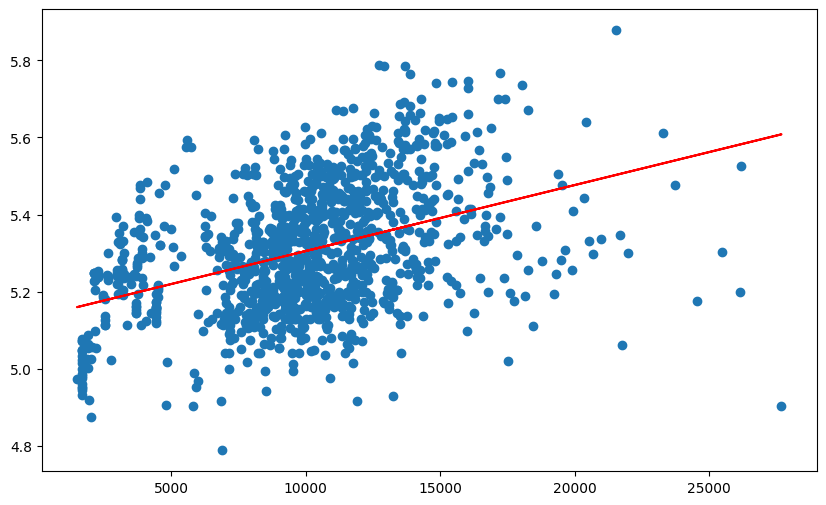

In [59]:
test = data[data['Lot.Area'] <= 30000]
# sns.scatterplot(x='Lot.Area', y='SalePrice', data=test)
# sns.regplot(x='Lot.Area', y='SalePrice', data=test, scatter=False)
plt.figure(figsize=(10, 6))
plt.scatter(x='Lot.Area', y='SalePrice', data=test)
m , b = np.polyfit(test['Lot.Area'], test['SalePrice'], 1)
plt.plot(test['Lot.Area'], m*test['Lot.Area'] + b, color='red');

print(m, b)

0.00033637056903743805 5.2239009035600334


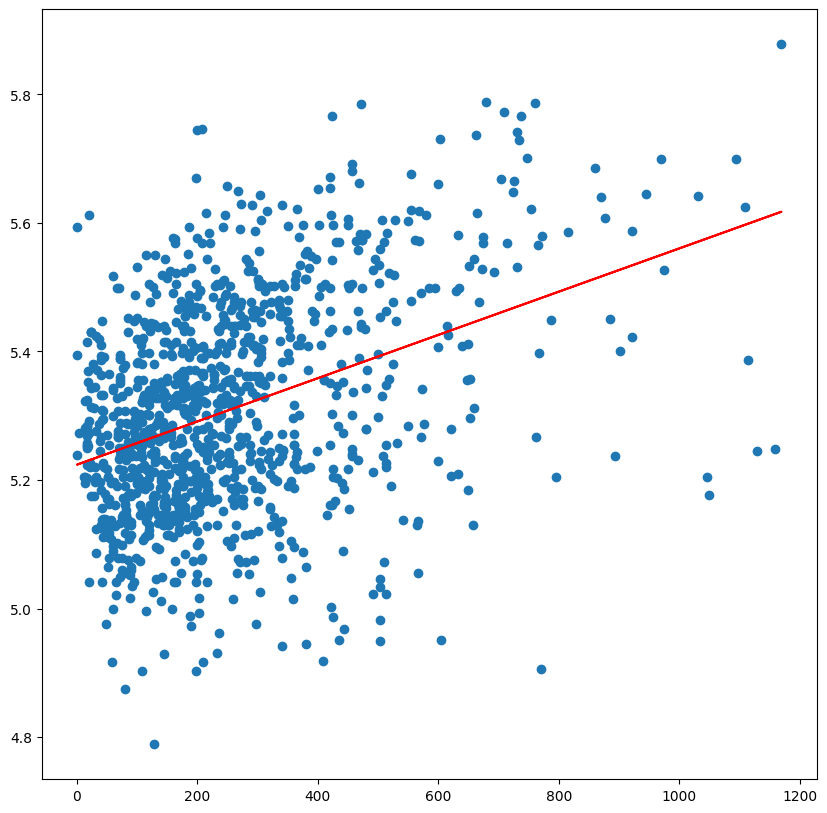

In [60]:
test = data[data['Mas.Vnr.Area'] <= 1200]
# sns.scatterplot(x='Mas.Vnr.Area', y='SalePrice', data=test)
# sns.regplot(x='Mas.Vnr.Area', y='SalePrice', data=test, scatter=False)
plt.figure(figsize=(10, 10))
plt.scatter(x='Mas.Vnr.Area', y='SalePrice', data=test)
m, b = np.polyfit(test['Mas.Vnr.Area'], test['SalePrice'], 1)
plt.plot(test['Mas.Vnr.Area'], m*test['Mas.Vnr.Area'] + b, color='red');

print (m, b)

In [61]:
print(model_data["Overall.Cond"].value_counts())
print(model_data["Overall.Qual"].value_counts())

Overall.Cond
3    826
4    172
5     91
2     24
6     23
1      9
7      8
0      1
Name: count, dtype: int64
Overall.Qual
3    306
4    284
5    227
2    189
6     99
7     26
1     22
0      1
Name: count, dtype: int64


In [62]:
test = data[data['Overall.Cond'] >= 1]
# scatter plot of Overall.Qual subplot with Overall.Cond

# sns.scatterplot(x='Overall.Qual', y='SalePrice', data=model_data)
sns.scatterplot(x='Overall.Cond', y='SalePrice', data=data)

# Plot regression line
# sns.regplot(x='Overall.Qual', y='SalePrice', data=model_data, scatter=False)
sns.regplot(x='Overall.Cond', y='SalePrice', data=data, scatter=False)

# Remove outliers


TypeError: Invalid comparison between dtype=category and int